Code block below is used to list the hardware used.

In [25]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

  # /bin/bash: line 1: nvidia-smi: command not found <-- this return indicates a GPU is not connected.

Sun Jun 16 09:36:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   52C    P8              17W /  72W |      4MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

The code below checks the available memory:

In [26]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 56.9 gigabytes of available RAM

You are using a high-RAM runtime!


In [27]:
# depending on your shell, you might need to add `\` before `[` and `]`.
!pip install -q flwr[simulation]

Now we will get the dataset.

This will require `torch` and `torchvision`.

Below is the `imports` section

In [28]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import flwr as fl
from collections import OrderedDict
from typing import Dict, Tuple
from flwr.common import NDArrays, Scalar

In [29]:
def get_mnist_dataset(data_path: str = "./data"):
  # This function will get the MNIST dataset, downloading it into the `data_path`
  # directory, if not is not in there already.
  # We will construct the train-test-split by converting images into tensors
  # and normalising them

  # Transformation to convert images to tensors and applying normalisation
  tr = Compose([ToTensor(), Normalize((0.1307),(0.3081))]) # --> mean and standard deviation figures

  # Prepare train and test data sets
  train_dataset = MNIST(data_path, train=True, download=True, transform=tr)
  test_dataset = MNIST(data_path, train=False, download=True, transform=tr)

  return train_dataset, test_dataset

We will run this code to check for issues, and then to explore the data.

In [30]:
train_dataset, test_dataset = get_mnist_dataset()

We can have an overview of the datasets by typing the object name on the command line:

In [31]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.1307, std=0.3081)
           )

In [32]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.1307, std=0.3081)
           )

We can also look at the distribution of the data, by constructing a histogram:

Text(0.5, 1.0, 'Class Label Distribution for the MNIST Dataset')

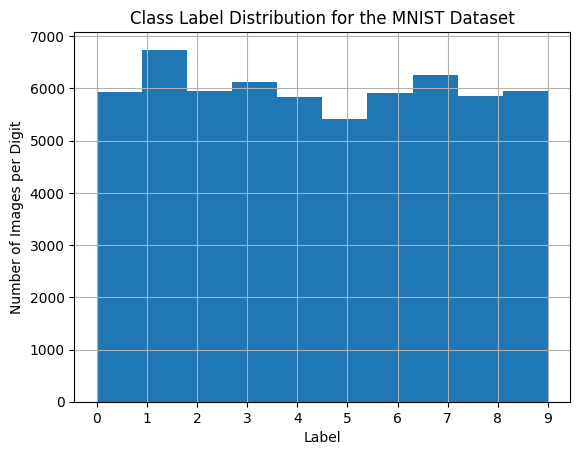

In [33]:
# Construct the histograms:
all_labels = train_dataset.targets
# len(all_labels)

# set creates a colelction of unique elements, since numpy arrays can contain duplicates
num_possible_labels = len(set(all_labels.numpy().tolist())) # counts unique labels, is 10

plt.hist(all_labels, bins=num_possible_labels)

# Plot formatting
plt.xticks(range(num_possible_labels))
plt.grid()
plt.xlabel("Label")
plt.ylabel("Number of Images per Digit")
plt.title("Class Label Distribution for the MNIST Dataset")

Now, we can take a look at some of the dataset images:

In [34]:
def visualise_n_random_samples(train_dataset_, n: int, verbose: bool = True):
  # Take n-examples at random
  idx = list(range(len(train_dataset_.data)))
  random.shuffle(idx)
  idx=idx[:n]
  verbose=False # This will stop the indices being printed
  if verbose:
    print(f"will display the images with the index: {idx}")

  # Construct canvas:
  num_cols = 8
  num_rows = int(np.ceil(len(idx)/num_cols))
  fig,axs = plt.subplots(figsize=(16, num_rows*2), nrows=num_rows, ncols=num_cols)

  # display images on the created canvas:
  for c_i, i in enumerate(idx):
    axs.flat[c_i].imshow(train_dataset_.data[i], cmap="gray")

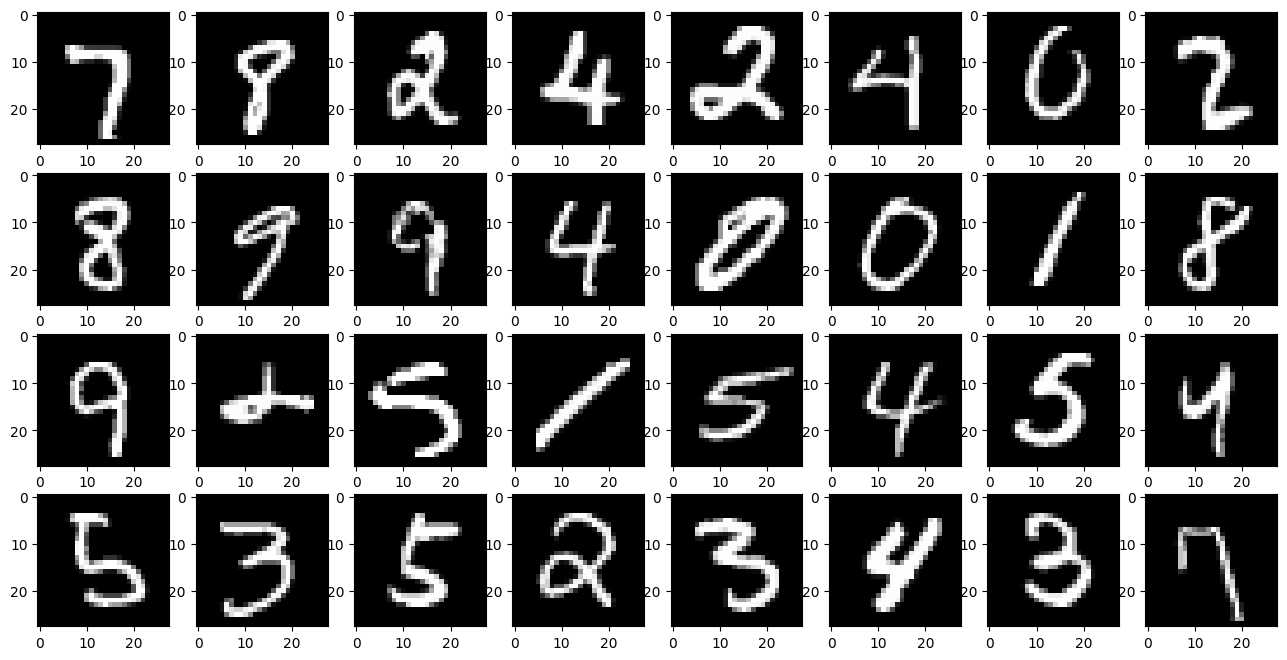

In [35]:
visualise_n_random_samples(train_dataset, n=32)

Now we will look at a simple CNN:

In [36]:
class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

We can inspect the model, for example, we can print the number of parameters:

In [37]:
model = Net(num_classes=10)
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 44426


Now for the training. A minimal training loop in PyTorch can be constructed with three functions:
- `train()`: this will train the model given a dataloader
- `test()`: this will  be used to evaluate the performance of the model on held-out data, e.g., training set
- `run_centralised()`: this will define additional elements (e.g., the optmiser) and run the training loop over N epochs

We can construct these as follows:

In [38]:
def train(net, trainloader, optimizer, epochs):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for _ in range(epochs):
        for images, labels in trainloader:
            optimizer.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
    return net


def test(net, testloader):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy


def run_centralised(epochs: int, lr: float, momentum: float = 0.9):
    """A minimal (but complete) training loop"""

    # instantiate the model
    model = Net(num_classes=10)

    # define optimiser with hyperparameters supplied
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # get dataset and construct a dataloaders
    trainset, testset = get_mnist_dataset()
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=128)

    # train for the specified number of epochs
    trained_model = train(model, trainloader, optim, epochs)

    # training is completed, then evaluate model on the test set
    loss, accuracy = test(trained_model, testloader)
    print(f"{loss = }")
    print(f"{accuracy = }")

Now we can run for a small number of epochs:

In [39]:
run_centralised(epochs=5, lr=0.01)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


loss = 3.3012596965563716
accuracy = 0.9868


# Federated Learning

To start desigbing a FL pipeline we need to meey one of the key properties in FL: each client has its own data partition. To do this with the MNIST dataset, we are going to generate N random partitions, were N is the number of clients in our FL system.

In [40]:
from torch.utils.data import random_split

def prepare_dataset(num_partitions: int, batch_size: int, val_ratio: float = 0.1):
    """This function partitions the training set into N disjoint
    subsets, each will become the local dataset of a client. This
    function also subsequently partitions each traininset partition
    into train and validation. The test set is left intact and will
    be used by the central server to asses the performance of the
    global model."""

    # get the MNIST dataset
    trainset, testset = get_mnist_dataset()

    # split trainset into `num_partitions` trainsets
    num_images = len(trainset) // num_partitions

    partition_len = [num_images] * num_partitions

    trainsets = random_split(
        trainset, partition_len, torch.Generator().manual_seed(42)
    )

    # create dataloaders with train+val support
    trainloaders = []
    valloaders = []
    for trainset_ in trainsets:
        num_total = len(trainset_)
        num_val = int(val_ratio * num_total)
        num_train = num_total - num_val

        for_train, for_val = random_split(
            trainset_, [num_train, num_val], torch.Generator().manual_seed(42)
        )

        trainloaders.append(
            DataLoader(for_train, batch_size=batch_size, shuffle=True, num_workers=2)
        )
        valloaders.append(
            DataLoader(for_val, batch_size=batch_size, shuffle=False, num_workers=2)
        )

    # create dataloader for the test set
    testloader = DataLoader(testset, batch_size=128)

    return trainloaders, valloaders, testloader

Now I will create 100 partitions and extract some statistics from one partition.

number of images: 540


Text(0.5, 1.0, 'Class labels distribution for MNIST')

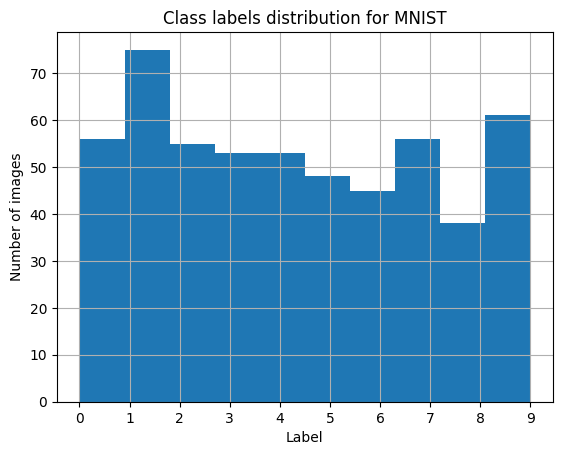

In [41]:
trainloaders, valloaders, testloader = prepare_dataset(
    num_partitions=100, batch_size=32
)

# first partition
train_partition = trainloaders[1].dataset

# count data points
partition_indices = train_partition.indices
print(f"number of images: {len(partition_indices)}")

# visualise histogram
plt.hist(train_partition.dataset.dataset.targets[partition_indices], bins=10)
plt.grid()
plt.xticks(range(10))
plt.xlabel("Label")
plt.ylabel("Number of images")
plt.title("Class labels distribution for MNIST")

It can be seen that this histogram is different to the one when the whole dataset was examined. Since the MNIST dataset is sampled in a IID fashion, the network will not experience sever data heterogeneity issues.

# Defining a Flower Client

A clinet in FL can be though as an entity that owns some data and trains a model using that data. A FL network can have many clients - up to hundreds or thousands.

A Flower client is a simple python class with 4 distinct methods:

- `fit()`: With this method, the client does on-device training for a number of epochs using its own data. At the end, the resulting model is sent back to the server.
- `evaluate()`: With this method, the server can evaluate the performance of the global model on the local validation set of a client. THis can be used for instance when there is no centralised dataset on the server for validation/test. Also, this method can be used to assess the degree of personalisation of the model being federated.
- `set_parameters()`: This method takes the parameters sent by the server and uses them to initialise the parameters of the local model that is ML framework specific (i.e., TF, PyTorch, etc.).
- `get_parameters()`: This extracts the parameters from the local model and transforms them into a losy of NumPy arrays. This ML framework-agnostic representation of the model will be sent to the sever.

In [42]:
# Confirm flwr is installed:
!pip install flwr

We define the client here:

In [43]:
class FlowerClient(fl.client.NumPyClient):
  def __init__(self, trainloader, valloader) -> None:
    super().__init__()

    self.trainloader = trainloader
    self.valloader = valloader
    self.model = Net(num_classes=10)

  def set_parameters(self, parameters):
      # With the model parameters received from the server,
      # overwrite the uninitialise model in this class with them.

      params_dict = zip(self.model.state_dict().keys(), parameters)
      state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
      # now replace the parameters
      self.model.load_state_dict(state_dict, strict=True)

  def get_parameters(self, config: Dict[str, Scalar]):
          """Extract all model parameters and convert them to a list of
          NumPy arrays. The server doesn't work with PyTorch/TF/etc."""
          return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

  def fit(self, parameters, config):
      """This method train the model using the parameters sent by the
      server on the dataset of this client. At then end, the parameters
      of the locally trained model are communicated back to the server"""

      # copy parameters sent by the server into client's local model
      self.set_parameters(parameters)

      # Define the optimiser: Essentially the same as in the centralised example above
      optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)

      # do local training: Essentially the same as in the centralised example above (but now using the client's data instead of the whole dataset)
      train(self.model, self.trainloader, optim, epochs=1)

      # return the model parameters to the server as well as extra info (number of training examples in this case)
      return self.get_parameters({}), len(self.trainloader), {}

  def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
      """Evaluate the model sent by the server on this client's
      local validation set. Then return performance metrics."""

      self.set_parameters(parameters)
      loss, accuracy = test(
          self.model, self.valloader
      )  # <-------------------------- calls the `test` function, just what we did in the centralised setting (but this time using the client's local validation set)
      # send statistics back to the server
      return float(loss), len(self.valloader), {"accuracy": accuracy}


In FL, the way clients perform local training makes use of the same principles as more traditional, centralised systems. The difference here is that the data is now much smaller, and it is never "seen" by the central server running the FL workload.

We can now define what strategy we want to use, so the updated models sent from the client back to the server at the end of the `fit()` method are aggretaged.

# Chosing a Flower Strategy

A strategy sits at the core of the FL experiment. It is involve in all stages of a FL pipeline: sampling clients; sending the _global model_ to the clinets so they can do `fit()`; receive the updated models and **aggregate** these to construct a new _global model_; define and execute global or federated evaluation; and more.

The Flower framework comes with [many stragegies built-in](https://github.com/adap/flower/tree/main/src/py/flwr/server/strategy) with more coming. For this work, we will use what is probably the most popular strategy: `FedAvg`.

The way `FedAvg` works is simple, but performs surprisingly well in practice. It is therefore one good strategy to start out experimentation. `FedAvg`, as the name suggests, comes from a new version of the _global model_ by taking the average of all the models sent bu clients participating in the round.

We will see how we can defind `FedAvg` using Flower. We use oc of the callbacks called `evaluate_fn` so we can easily evaluate the state of the global model using a small centralised testset. Note this functionality is user-defined since it requires a choice in terms of ML framework.

This being said, centralised evaluation of the global model is only possible if there exists a centralised dataset for validation is not possible, so the only solution is to federate the evaluation of the _global model_. This is the default behaviour in Flower. If you don't specify the `evaluate_fn` argument in your strategy, then, centralised global evaluation won't be performed.

In [44]:
def get_evaluate_fn(testloader):
    # This is a function that returns a function. The returned
    # function (i.e. `evaluate_fn`) will be executed by the strategy
    # at the end of each round to evaluate the state of the global
    # model.

    def evaluate_fn(server_round: int, parameters, config):
        # This function is executed by the strategy it will instantiate
        # a model and replace its parameters with those from the global model.
        # The, the model will be evaluate on the test set (recall this is the
        # whole MNIST test set)."""

        model = Net(num_classes=10)

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        # call test
        loss, accuracy = test(
            model, testloader
        )  # calls the `test` function, just what we did in the centralised setting
        return loss, {"accuracy": accuracy}

    return evaluate_fn


# now we can define the strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.1,  # let's sample 10% of the client each round to do local training
    fraction_evaluate=0.1,  # after each round, let's sample 20% of the clients to asses how well the global model is doing
    min_available_clients=100,  # total number of clients available in the experiment
    evaluate_fn=get_evaluate_fn(testloader),
)  # a callback to a function that the strategy can execute to evaluate the state of the global model on a centralised dataset

So far we have:
- created the dataset partitions (one per client)
- defined the client class
- decided on a strategy to use

Now we need one final fucntion: we will create another callback that the Simulation Engine will use in order to span VirtualClients. Here we construct a FlowerClient object, assigning each theor own data partition

In [45]:
def generate_client_fn(trainloaders, valloaders):
    def client_fn(cid: str):
        """Returns a FlowerClient containing the cid-th data partition"""

        return FlowerClient(
            trainloader=trainloaders[int(cid)], valloader=valloaders[int(cid)]
        ).to_client()

    return client_fn


client_fn_callback = generate_client_fn(trainloaders, valloaders)

And now we can launch the FL experiment using Flower simulator.

In [46]:
!pip install flwr[simulation]

In [47]:
history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,  # a callback to construct a client
    num_clients=100,  # total number of clients in the experiment
    config=fl.server.ServerConfig(num_rounds=10),  # let's run for 10 rounds
    strategy=strategy,  # the strategy that will orchestrate the whole FL pipeline
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-16 09:37:52,295	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 16980343603.0, 'memory': 33960687207.0, 'node:__internal_head__': 1.0, 'accelerator_type:L4': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 12.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 12 actors
INFO :      

Completing 10 rounds should take less than 2 minites on a CPU-only Colab instance.

We can use teh returned `Histpry` object to either save the results to disk or do some visualisations (or both, of course). Below you can see how youc an plot the centralised accuracy obtained at the end of each round (including at the very beginning of the experiment for the _global model_. This is what the function `evaluate_fn()` that we passed to the strategy reports.  

history.metrics_centralized = {'accuracy': [(0, 0.1642), (1, 0.2107), (2, 0.3301), (3, 0.4476), (4, 0.4439), (5, 0.6516), (6, 0.7325), (7, 0.7936), (8, 0.8296), (9, 0.8505), (10, 0.8748)]}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'MNIST (IID Data): 100 clients total, 10 clients per round')

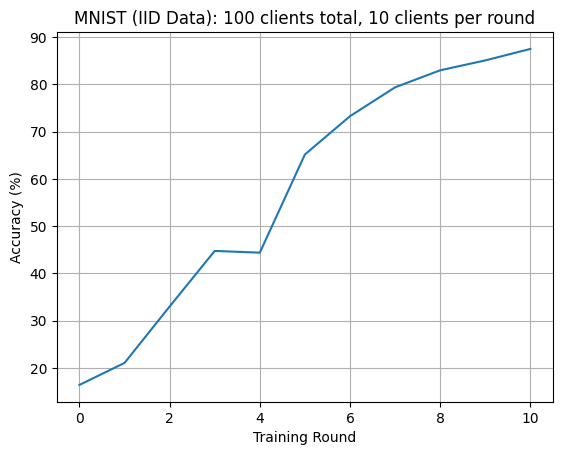

In [48]:
print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized["accuracy"]
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Training Round")
plt.title("MNIST (IID Data): 100 clients total, 10 clients per round")

In [49]:
!git status

fatal: not a git repository (or any of the parent directories): .git


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
